In [1]:
from pathlib import Path   # Import Path for filesystem operations

# Loop through a list of project subfolders
for p in ["data/raw", "data/staging", "data/warehouse"]:
    # Create the directory (and its parents if needed)
    # - parents=True: creates parent directories if they don’t already exist
    # - exist_ok=True: does nothing if the folder already exists (avoids errors)
    Path(p).mkdir(parents=True, exist_ok=True)

# Show the absolute path of the current working directory
Path(".").absolute()


WindowsPath('C:/Users/mamat/Documents/nyc')

In [2]:
import shutil                # Import shutil for high-level file operations

# Define the source file path (where the raw parquet file currently is)
src = Path(r"C:\Users\mamat\Downloads\yellow_tripdata_2024-01.parquet")

# Define the destination file path (where we want to copy it inside the project structure)
dst = Path("data/raw/yellow_tripdata_2024-01.parquet")

# Check if the source file exists AND the destination file does not already exist
if src.exists() and not dst.exists():
    # Copy the file from Downloads to the project "data/raw" folder
    # copy2() preserves metadata such as timestamps
    shutil.copy2(src, dst)

# Print confirmation: 
# - dst.exists() → True if the copy is successful (file exists at destination)
# - dst → shows the destination path
print("Raw file at:", dst.exists(), dst)


Raw file at: True data\raw\yellow_tripdata_2024-01.parquet


In [3]:
import pandas as pd   # Import pandas for data analysis and manipulation

# Define the path to the raw parquet file (January 2024 Yellow Taxi data)
raw_path = "data/raw/yellow_tripdata_2024-01.parquet"

# Load the parquet file into a pandas DataFrame
# - Parquet is a columnar storage format that’s very efficient for large datasets
df = pd.read_parquet(raw_path)

# Print the number of rows (trips) in the dataset
print("rows:", len(df))

# Display the first 5 rows of the DataFrame
# - Useful for inspecting column names and data values
df.head()


rows: 2964624


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [4]:
import numpy as np
import pandas as pd

def clean_add_features(df: pd.DataFrame) -> pd.DataFrame:
    # Make a copy so the original DataFrame is not modified in-place
    df = df.copy()

    # ----------------------------------------------------------------
    # 1. Convert pickup/dropoff timestamps to proper datetime objects
    # ----------------------------------------------------------------
    # errors="coerce": if parsing fails, set the value to NaT (missing datetime)
    for c in ["tpep_pickup_datetime", "tpep_dropoff_datetime"]:
        df[c] = pd.to_datetime(df[c], errors="coerce")

    # ----------------------------------------------------------------
    # 2. Create derived time-based features
    # ----------------------------------------------------------------
    df["duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60.0
    # trip duration in minutes

    df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour   # hour of day (0–23)
    df["pickup_date"] = df["tpep_pickup_datetime"].dt.date   # pickup calendar date
    df["year"]        = df["tpep_pickup_datetime"].dt.year   # pickup year (e.g., 2024)
    df["month"]       = df["tpep_pickup_datetime"].dt.month  # pickup month (1–12)

    # ----------------------------------------------------------------
    # 3. Ensure required columns are present (drop rows with missing values)
    # ----------------------------------------------------------------
    required = [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "PULocationID",
        "DOLocationID",
        "fare_amount",
        "total_amount"
    ]
    df = df.dropna(subset=required)

    # ----------------------------------------------------------------
    # 4. Logical filters and outlier removal
    # ----------------------------------------------------------------
    df = df[(df["duration_min"] >= 1) & (df["duration_min"] <= 180)]
    # keep trips lasting 1–180 minutes (1 min to 3 hours)

    df["trip_distance"] = df["trip_distance"].fillna(0)
    # fill missing trip_distance values with 0

    df = df[(df["trip_distance"] >= 0) & (df["trip_distance"] <= 100)]
    # keep trips between 0 and 100 miles

    df = df[(df["fare_amount"] >= 0) & (df["total_amount"] >= 0)]
    # keep only non-negative fares and totals

    # ----------------------------------------------------------------
    # 5. Fare-per-mile guardrails (only if distance > 0)
    # ----------------------------------------------------------------
    with np.errstate(divide="ignore", invalid="ignore"):
        fpm = df["fare_amount"] / df["trip_distance"].replace({0: np.nan})
        # replace distance=0 with NaN to avoid division by zero

    df["fare_per_mile"] = fpm
    # keep rows where fare_per_mile is between $0.50 and $25,
    # or where fare_per_mile is NaN (for zero-distance trips)
    df = df[
        (df["fare_per_mile"].isna()) |
        ((df["fare_per_mile"] >= 0.5) & (df["fare_per_mile"] <= 25))
    ]

    # ----------------------------------------------------------------
    # 6. De-duplicate records
    # ----------------------------------------------------------------
    before = len(df)
    dedup_cols = [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "PULocationID",
        "DOLocationID",
        "total_amount"
    ]
    df = df.drop_duplicates(subset=dedup_cols, keep="first")
    print(f"Deduplicated: removed {before - len(df)} rows")

    # ----------------------------------------------------------------
    # 7. Return the cleaned DataFrame
    # ----------------------------------------------------------------
    return df


# Apply cleaning function to the raw January DataFrame
cleaned = clean_add_features(df)

# Compare sizes: (original rows, cleaned rows, show first 2 rows of cleaned data)
len(df), len(cleaned), cleaned.head(2)


Deduplicated: removed 0 rows


(2964624,
 2880422,
    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
 0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
 1         1  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
 
    trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
 0           1.72         1.0                  N           186            79   
 1           1.80         1.0                  N           140           236   
 
    payment_type  ...  improvement_surcharge  total_amount  \
 0             2  ...                    1.0         22.70   
 1             1  ...                    1.0         18.75   
 
    congestion_surcharge  Airport_fee  duration_min  pickup_hour  pickup_date  \
 0                   2.5          0.0          19.8            0   2024-01-01   
 1                   2.5          0.0           6.6            0   2024-01-01   
 
    year  month  fare_per_mile  
 0  2024      1      10.290698  
 1  2024 

In [5]:
# Define the warehouse output directory
out_dir = "data/warehouse/yellow_clean"

# Save the cleaned DataFrame into Parquet format
# - engine="pyarrow": parquet backend (needed for partitioned writes in pandas >= 2.0)
# - index=False: do not include the DataFrame index as a column in the file
# - partition_cols=["year","month"]: automatically split data into subfolders
#   grouped by year and month → this makes querying faster later
cleaned.to_parquet(
    out_dir,
    engine="pyarrow",
    index=False,
    partition_cols=["year", "month"]
)

# Return the output directory string so you can check the location
out_dir


'data/warehouse/yellow_clean'

In [6]:
clean_dir = "data/warehouse/yellow_clean"
df_clean = pd.read_parquet(clean_dir, engine="pyarrow")  # reads the whole dataset (all year/month partitions)
len(df_clean), df_clean.head(2)

(11599610,
    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
 0         2  2002-12-31 22:59:39   2002-12-31 23:05:41              1.0   
 1         2  2002-12-31 22:59:39   2002-12-31 23:05:41              1.0   
 
    trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
 0           0.63         1.0                  N           170           170   
 1           0.63         1.0                  N           170           170   
 
    payment_type  ...  improvement_surcharge  total_amount  \
 0             3  ...                    1.0          10.5   
 1             3  ...                    1.0          10.5   
 
    congestion_surcharge  Airport_fee  duration_min  pickup_hour  pickup_date  \
 0                   2.5          0.0      6.033333           22   2002-12-31   
 1                   2.5          0.0      6.033333           22   2002-12-31   
 
    fare_per_mile  year  month  
 0       10.31746  2002     12  
 1       10.31746 

In [7]:
trips_by_hour = (df_clean
                 .assign(hour=df_clean["tpep_pickup_datetime"].dt.hour)
                 .groupby("hour", as_index=False)
                 .size()
                 .rename(columns={"size": "trips"})
                 .sort_values("hour"))
trips_by_hour


,hour,trips
0,0,309816
1,1,210538
2,2,144492
3,3,93558
4,4,62976
5,5,69488
6,6,159126
7,7,329540
8,8,463240
9,9,503094


In [8]:
monthly_rev = (df_clean
               .assign(ym=df_clean["tpep_pickup_datetime"].dt.to_period("M").astype(str))
               .groupby("ym", as_index=False)
               .agg(total_revenue=("total_amount","sum"),
                    avg_total=("total_amount","mean"),
                    trips=("total_amount","size"))
               .sort_values("ym"))
monthly_rev

,ym,total_revenue,avg_total,trips
0,2002-12,2.100000e+01,10.500000,2
1,2008-12,3.980000e+01,19.900000,2
2,2009-01,2.897000e+02,36.212500,8
3,2023-12,4.492400e+02,22.462000,20
4,2024-01,1.571958e+08,27.287005,5760830
5,2024-02,1.586737e+08,27.175990,5838744
6,2024-03,1.746600e+02,43.665000,4


In [9]:
raw_feb = Path(r"C:\Users\mamat\Downloads\yellow_tripdata_2024-02.parquet")


In [10]:
dst = Path("data/raw/yellow_tripdata_2024-02.parquet")
if raw_feb.exists() and not dst.exists():
    import shutil
    shutil.copy2(raw_feb, dst)

In [11]:
# load with pandas
df_feb = pd.read_parquet(dst)
print("Rows in Feb raw file:", len(df_feb))
df_feb.head()

Rows in Feb raw file: 3007526


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-02-01 00:04:45,2024-02-01 00:19:58,1.0,4.39,1.0,N,68,236,1,20.5,1.0,0.5,1.28,0.00,1.0,26.78,2.5,0.00
1,2,2024-02-01 00:56:31,2024-02-01 01:10:53,1.0,7.71,1.0,N,48,243,1,31.0,1.0,0.5,9.00,0.00,1.0,45.00,2.5,0.00
2,2,2024-02-01 00:07:50,2024-02-01 00:43:12,2.0,28.69,2.0,N,132,261,2,70.0,0.0,0.5,0.00,6.94,1.0,82.69,2.5,1.75
3,1,2024-02-01 00:01:49,2024-02-01 00:10:47,1.0,1.10,1.0,N,161,163,1,9.3,3.5,0.5,2.85,0.00,1.0,17.15,2.5,0.00
4,1,2024-02-01 00:37:35,2024-02-01 00:51:15,1.0,2.60,1.0,N,246,79,2,15.6,3.5,0.5,0.00,0.00,1.0,20.60,2.5,0.00


In [12]:
import numpy as np

def clean_add_features(df: pd.DataFrame) -> pd.DataFrame:
    # Work on a copy so the original DataFrame isn't modified outside this function
    df = df.copy()

    # --------------------------------------------------------------------
    # 1. Convert timestamp columns to datetime
    # --------------------------------------------------------------------
    # This ensures pickup and dropoff columns are proper datetime objects
    # so we can safely calculate durations and extract time features.
    for c in ["tpep_pickup_datetime", "tpep_dropoff_datetime"]:
        df[c] = pd.to_datetime(df[c], errors="coerce")  
        # errors="coerce" → invalid values become NaT (missing datetime)

    # --------------------------------------------------------------------
    # 2. Add derived (engineered) time-based features
    # --------------------------------------------------------------------
    # Duration of trip in minutes
    df["duration_min"] = (
        (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"])
        .dt.total_seconds() / 60.0
    )
    # Hour of day when pickup happened (0–23)
    df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
    # Date only (without time)
    df["pickup_date"] = df["tpep_pickup_datetime"].dt.date
    # Year (e.g., 2024)
    df["year"] = df["tpep_pickup_datetime"].dt.year
    # Month (1–12)
    df["month"] = df["tpep_pickup_datetime"].dt.month

    # --------------------------------------------------------------------
    # 3. Drop rows missing required values
    # --------------------------------------------------------------------
    # Without these fields, the trip record is incomplete and not usable.
    required = [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "PULocationID",
        "DOLocationID",
        "fare_amount",
        "total_amount",
    ]
    df = df.dropna(subset=required)

    # --------------------------------------------------------------------
    # 4. Apply logical filters and remove outliers
    # --------------------------------------------------------------------
    # Keep trips lasting between 1 minute and 180 minutes (3 hours)
    df = df[(df["duration_min"] >= 1) & (df["duration_min"] <= 180)]

    # Replace missing trip_distance with 0
    df["trip_distance"] = df["trip_distance"].fillna(0)

    # Keep only trips between 0 and 100 miles
    df = df[(df["trip_distance"] >= 0) & (df["trip_distance"] <= 100)]

    # Keep only trips where fares and totals are non-negative
    df = df[(df["fare_amount"] >= 0) & (df["total_amount"] >= 0)]

    # --------------------------------------------------------------------
    # 5. Compute and validate fare per mile
    # --------------------------------------------------------------------
    # If trip_distance is zero, ignore (replace with NaN to avoid div-by-zero).
    with np.errstate(divide="ignore", invalid="ignore"):
        fpm = df["fare_amount"] / df["trip_distance"].replace({0: np.nan})
    df["fare_per_mile"] = fpm

    # Keep only trips where:
    # - fare_per_mile is missing (NaN, for zero distance trips)
    # - or fare_per_mile is between $0.50 and $25
    df = df[
        (df["fare_per_mile"].isna())
        | ((df["fare_per_mile"] >= 0.5) & (df["fare_per_mile"] <= 25))
    ]

    # --------------------------------------------------------------------
    # 6. Deduplicate trip records
    # --------------------------------------------------------------------
    before = len(df)
    dedup_cols = [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "PULocationID",
        "DOLocationID",
        "total_amount",
    ]
    # Drop duplicate trips based on key identifiers, keeping the first occurrence
    df = df.drop_duplicates(subset=dedup_cols, keep="first")
    print(f"Deduplicated: removed {before - len(df)} rows")

    # --------------------------------------------------------------------
    # 7. Return the cleaned DataFrame
    # --------------------------------------------------------------------
    return df


In [13]:
cleaned_feb = clean_add_features(df_feb)

out_dir = "data/warehouse/yellow_clean"
cleaned_feb.to_parquet(out_dir, engine="pyarrow", index=False, partition_cols=["year","month"])

print("Cleaned Feb data saved under:", out_dir)


Deduplicated: removed 1 rows
Cleaned Feb data saved under: data/warehouse/yellow_clean


In [14]:
# Reload the partitioned warehouse parquet data (January + February already saved there)
import pandas as pd
df_clean = pd.read_parquet("data/warehouse/yellow_clean", engine="pyarrow")

# ----------------------------------------------------------------
# 1. Filter only trips from January and February 2024
# ----------------------------------------------------------------
df_clean = df_clean[
    (df_clean["tpep_pickup_datetime"].dt.year == 2024) &          # only year 2024
    (df_clean["tpep_pickup_datetime"].dt.month.isin([1, 2]))      # only months 1 and 2
].copy()

# ----------------------------------------------------------------
# 2. Add helper columns for time-based analysis
# ----------------------------------------------------------------
df_clean["ym"]   = df_clean["tpep_pickup_datetime"].dt.to_period("M").astype(str)
# year-month as a string like "2024-01", "2024-02"

df_clean["date"] = df_clean["tpep_pickup_datetime"].dt.date
# calendar date only (YYYY-MM-DD)

df_clean["hour"] = df_clean["tpep_pickup_datetime"].dt.hour
# pickup hour of the day (0–23)

df_clean["dow"]  = df_clean["tpep_pickup_datetime"].dt.dayofweek
# day of week (0=Monday … 6=Sunday)

df_clean["is_weekend"] = df_clean["dow"].isin([5, 6])
# boolean: True if pickup on Saturday or Sunday

# ----------------------------------------------------------------
# 3. Map numeric payment_type codes into human-readable names
#    (based on NYC TLC Yellow Taxi trip records documentation)
# ----------------------------------------------------------------
pay_map = {
    1: "Credit card",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided trip"
}
df_clean["payment_type_name"] = df_clean["payment_type"].map(pay_map).fillna("Other")

# ----------------------------------------------------------------
# 4. Preview the enriched DataFrame
# ----------------------------------------------------------------
df_clean.head(3)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pickup_date,fare_per_mile,year,month,ym,date,hour,dow,is_weekend,payment_type_name
34,2,2024-01-31 23:59:53,2024-02-01 00:18:35,1.0,6.95,1.0,N,249,166,1,...,2024-01-31,4.359712,2024,1,2024-01,2024-01-31,23,2,False,Credit card
35,2,2024-01-31 23:59:24,2024-02-01 00:06:13,1.0,1.28,1.0,N,68,137,2,...,2024-01-31,7.265625,2024,1,2024-01,2024-01-31,23,2,False,Cash
36,2,2024-01-31 23:57:33,2024-02-01 00:05:48,1.0,1.40,1.0,N,90,79,1,...,2024-01-31,7.142857,2024,1,2024-01,2024-01-31,23,2,False,Credit card


In [15]:
trips_by_month = (
    df_clean
    .groupby("ym")        # group trips by year-month (e.g., "2024-01", "2024-02")
    .size()               # count number of trips in each group
    .rename("trips")      # rename the count column from "size" → "trips"
    .reset_index()        # turn group labels back into a DataFrame column
    .sort_values("ym")    # sort chronologically by year-month
)

# Display result
trips_by_month



,ym,trips
0,2024-01,5760840
1,2024-02,8758113


In [16]:
trips_by_hour = (
    df_clean
    .groupby("hour")                # group trips by pickup hour (0–23)
    .size()                         # count number of trips per group
    .reset_index(name="trips")      # turn group labels into a column, name count column "trips"
    .sort_values("hour")            # sort from hour 0 → 23
)

# Show result
trips_by_hour



,hour,trips
0,0,388659
1,1,264447
2,2,180994
3,3,117024
4,4,78940
5,5,86475
6,6,198559
7,7,412495
8,8,580392
9,9,629059


In [17]:
# Compare weekday vs weekend taxi activity
wkwd = (
    df_clean
    .groupby("is_weekend")                         # group trips into weekend vs weekday
    .agg(
        trips=("total_amount", "size"),            # total number of trips
        avg_duration_min=("duration_min", "mean"), # average trip duration in minutes
        avg_distance_mi=("trip_distance", "mean")  # average trip distance in miles
    )
    .reset_index()
    .replace({"is_weekend": {False: "Weekday", True: "Weekend"}})  # map boolean → label
)

# Show result
wkwd


,is_weekend,trips,avg_duration_min,avg_distance_mi
0,Weekday,10660390,15.719700,3.232008
1,Weekend,3858563,14.040682,3.197620


In [18]:
# Trips per day of week (0=Mon … 6=Sun)
trips_by_dow = (
    df_clean
    .groupby("dow")                  # group by day-of-week code (0=Mon, …, 6=Sun)
    .size()                          # count number of trips in each group
    .reset_index(name="trips")       # convert result into a DataFrame, name count column "trips"
    .sort_values("dow")              # ensure order is 0 → 6
)

# Show result
trips_by_dow


,dow,trips
0,0,1788541
1,1,2028877
2,2,2248359
3,3,2563397
4,4,2031216
5,5,2115053
6,6,1743510


In [19]:
# Top 10 pickup zones by number of trips
top_pu = (
    df_clean
    .groupby("PULocationID")             # group trips by pickup zone ID
    .size()                              # count trips per zone
    .reset_index(name="trips")           # convert result to DataFrame, call the count column "trips"
    .sort_values("trips", ascending=False)  # sort from most → least trips
    .head(10)                            # keep only the top 10 pickup zones
)

# Show result
top_pu


,PULocationID,trips
156,161,710841
232,237,693314
231,236,662934
127,132,632174
157,162,518286
225,230,501764
181,186,497002
137,142,489922
234,239,441014
133,138,431776


In [20]:
# Top 10 dropoff zones by number of trips
top_do = (
    df_clean
    .groupby("DOLocationID")              # group trips by dropoff zone ID
    .size()                               # count trips per zone
    .reset_index(name="trips")            # make it a DataFrame, name count column "trips"
    .sort_values("trips", ascending=False)  # sort from most → least trips
    .head(10)                             # keep only the top 10
)

# Show result
top_do


,DOLocationID,trips
231,236,693146
232,237,633302
157,161,547969
234,239,433725
166,170,431991
225,230,429130
138,142,427632
158,162,411198
137,141,406905
67,68,371307


In [21]:
# Monthly revenue and average fare metrics
monthly_rev = (
    df_clean
    .groupby("ym")                                   # group by year-month string (e.g. "2024-01")
    .agg(
        total_revenue=("total_amount", "sum"),       # total revenue = sum of total_amount
        avg_total_per_trip=("total_amount", "mean"), # average revenue per trip
        trips=("total_amount", "size")               # number of trips (row count)
    )
    .reset_index()                                   # turn group labels into a column
    .sort_values("ym")                               # sort chronologically
)

# Show result
monthly_rev



,ym,total_revenue,avg_total_per_trip,trips
0,2024-01,1.571961e+08,27.287003,5760840
1,2024-02,2.380104e+08,27.175989,8758113


In [22]:
# Fare distribution summary statistics
fare_stats = (
    df_clean["total_amount"]
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])  # basic stats + custom percentiles
    .to_frame("total_amount_stats")                           # convert Series → DataFrame
)

# Show result
fare_stats



,total_amount_stats
count,1.451895e+07
mean,2.722004e+01
std,2.149978e+01
min,0.000000e+00
10%,1.288000e+01
25%,1.568000e+01
50%,2.030000e+01
75%,2.880000e+01
90%,5.123000e+01
99%,1.029200e+02


In [23]:
# Revenue breakdown by payment type (Jan+Feb combined)
rev_by_pay = (
    df_clean
    .groupby("payment_type_name")                    # group by readable payment type name
    .agg(
        trips=("total_amount", "size"),              # number of trips
        total_revenue=("total_amount", "sum"),       # total revenue from that payment type
        avg_total=("total_amount", "mean")           # average fare per trip
    )
    .reset_index()                                   # turn group labels into a column
    .sort_values("total_revenue", ascending=False)   # sort by revenue (highest first)
)

# Show result
rev_by_pay



,payment_type_name,trips,total_revenue,avg_total
1,Credit card,11550800,3.233184e+08,27.990997
0,Cash,2014106,4.777462e+07,23.720010
4,Other,797994,2.030160e+07,25.440791
2,Dispute,107212,2.717690e+06,25.348748
3,No charge,48841,1.094128e+06,22.401843


In [24]:
#Tip rate & averages by payment type
df_clean["tip_rate"] = np.where(
    df_clean["total_amount"]>0,
    df_clean["tip_amount"] / df_clean["total_amount"],
    np.nan
)

tips_by_pay = (
    df_clean.groupby("payment_type_name")
    .agg(avg_tip_amount=("tip_amount","mean"),
         median_tip_amount=("tip_amount","median"),
         avg_tip_rate=("tip_rate","mean"),
         trips=("tip_amount","size"))
    .reset_index()
    .sort_values("avg_tip_amount", ascending=False)
)
tips_by_pay


,payment_type_name,avg_tip_amount,median_tip_amount,avg_tip_rate,trips
1,Credit card,4.134657,3.15,0.147425,11550800
4,Other,1.301343,0.00,0.041243,797994
3,No charge,0.009873,0.00,0.000231,48841
2,Dispute,0.008859,0.00,0.000203,107212
0,Cash,0.000174,0.00,0.000008,2014106


In [25]:
#Tip behavior by month (Jan vs Feb)
tips_by_month = (
    df_clean.assign(tip_rate=np.where(df_clean["total_amount"]>0, df_clean["tip_amount"]/df_clean["total_amount"], np.nan))
            .groupby("ym")
            .agg(avg_tip_amount=("tip_amount","mean"),
                 median_tip_amount=("tip_amount","median"),
                 avg_tip_rate=("tip_rate","mean"))
            .reset_index()
            .sort_values("ym")
)
tips_by_month


,ym,avg_tip_amount,median_tip_amount,avg_tip_rate
0,2024-01,3.377000,2.74,0.120243
1,2024-02,3.350549,2.74,0.119107


In [26]:
import os
os.makedirs("reports/figures", exist_ok=True)

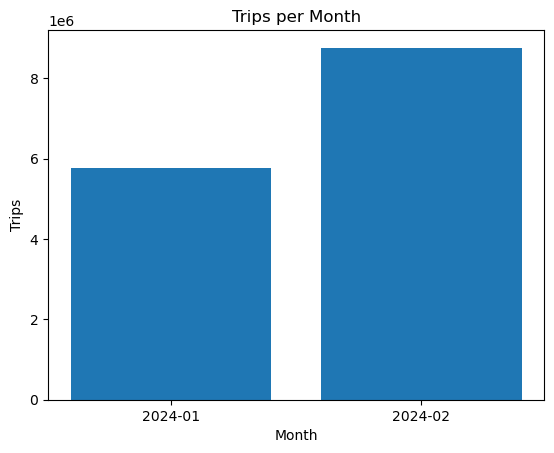

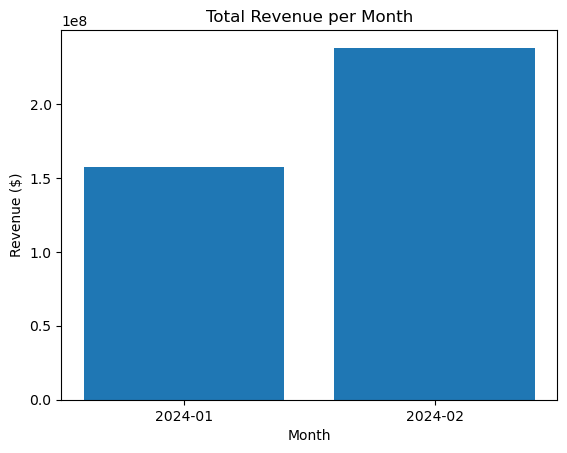

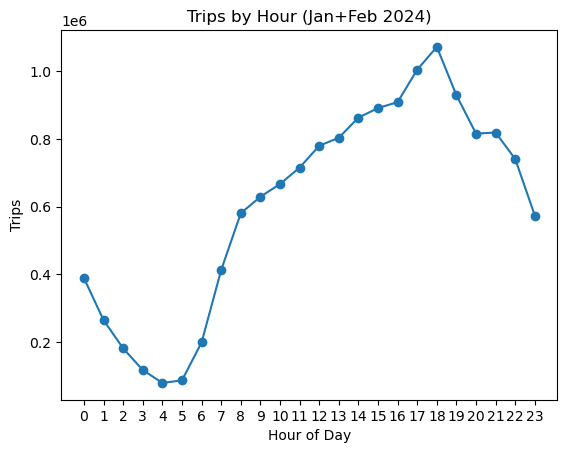

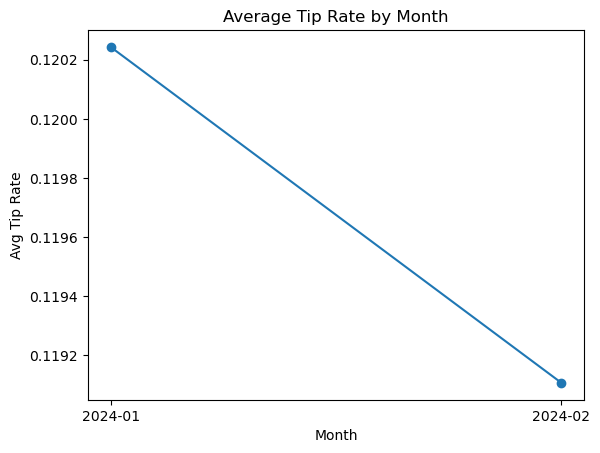

In [27]:
import matplotlib.pyplot as plt  # import matplotlib for plotting

# ================================
# Trips per month (bar chart)
# ================================
plt.figure()  # create a new empty figure
plt.bar(trips_by_month["ym"], trips_by_month["trips"])  # create a bar chart: x = month, y = trip counts
plt.title("Trips per Month")  # add chart title
plt.xlabel("Month")  # label x-axis
plt.ylabel("Trips")  # label y-axis
plt.savefig("reports/figures/trips_per_month.png", dpi=300, bbox_inches="tight")  # save figure as PNG in reports/figures
plt.show()  # display the figure on screen

# ================================
# Revenue per month (bar chart)
# ================================
plt.figure()  # create a new empty figure
plt.bar(monthly_rev["ym"], monthly_rev["total_revenue"])  # bar chart: x = month, y = total revenue
plt.title("Total Revenue per Month")  # add chart title
plt.xlabel("Month")  # label x-axis
plt.ylabel("Revenue ($)")  # label y-axis with units in dollars
plt.savefig("reports/figures/revenue_per_month.png", dpi=300, bbox_inches="tight")  # save figure as PNG
plt.show()  # display the figure

# ================================
# Trips by hour (line chart)
# ================================
plt.figure()  # create a new empty figure
plt.plot(trips_by_hour["hour"], trips_by_hour["trips"], marker="o")  # line plot: x = hour of day, y = trips; add circle markers
plt.title("Trips by Hour (Jan+Feb 2024)")  # add chart title
plt.xlabel("Hour of Day")  # label x-axis
plt.ylabel("Trips")  # label y-axis
plt.xticks(range(0,24))  # set x-axis ticks to show all 24 hours (0–23)
plt.savefig("reports/figures/trips_by_hour.png", dpi=300, bbox_inches="tight")  # save figure as PNG
plt.show()  # display the figure

# ================================
# Tip rate by month (line chart)
# ================================
plt.figure()  # create a new empty figure
plt.plot(tips_by_month["ym"], tips_by_month["avg_tip_rate"], marker="o")  # line plot: x = month, y = avg tip rate; add circle markers
plt.title("Average Tip Rate by Month")  # add chart title
plt.xlabel("Month")  # label x-axis
plt.ylabel("Avg Tip Rate")  # label y-axis
plt.savefig("reports/figures/tip_rate_by_month.png", dpi=300, bbox_inches="tight")  # save figure as PNG
plt.show()  # display the figure


In [28]:
from pathlib import Path  # import Path class for handling directories and paths
Path("reports").mkdir(exist_ok=True)  # create "reports" folder if it does not already exist

# save each summary DataFrame as a CSV file in the reports folder
trips_by_month.to_csv("reports/trips_by_month.csv", index=False)  # trips per month
monthly_rev.to_csv("reports/monthly_revenue.csv", index=False)    # revenue per month
trips_by_hour.to_csv("reports/trips_by_hour.csv", index=False)    # trips per hour
rev_by_pay.to_csv("reports/revenue_by_payment_type.csv", index=False)  # revenue by payment type
tips_by_month.to_csv("reports/tips_by_month.csv", index=False)    # tips by month

"Saved CSVs in /reports"  # final string output (just a message, not a print)


'Saved CSVs in /reports'

In [29]:
zone_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"  
# URL to the Taxi Zone Lookup CSV file (contains NYC taxi zone IDs, boroughs, and zone names)

zones = pd.read_csv(zone_url)  
# read the CSV file directly from the URL into a pandas DataFrame called "zones"

zones.head()  
# display the first 5 rows of the DataFrame to quickly preview the data


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [30]:
#Joining zones to your trips pickup
top_pu = (
    df_clean.groupby("PULocationID")
    .size()
    .reset_index(name="trips")
    .merge(zones, left_on="PULocationID", right_on="LocationID", how="left")
    .sort_values("trips", ascending=False)
    .head(10)
)
top_pu[["PULocationID","Borough","Zone","trips"]]


,PULocationID,Borough,Zone,trips
156,161,Manhattan,Midtown Center,710841
232,237,Manhattan,Upper East Side South,693314
231,236,Manhattan,Upper East Side North,662934
127,132,Queens,JFK Airport,632174
157,162,Manhattan,Midtown East,518286
225,230,Manhattan,Times Sq/Theatre District,501764
181,186,Manhattan,Penn Station/Madison Sq West,497002
137,142,Manhattan,Lincoln Square East,489922
234,239,Manhattan,Upper West Side South,441014
133,138,Queens,LaGuardia Airport,431776


In [31]:
#Joining zones to your trips dropoff
top_do = (
    df_clean.groupby("DOLocationID")
    .size()
    .reset_index(name="trips")
    .merge(zones, left_on="DOLocationID", right_on="LocationID", how="left")
    .sort_values("trips", ascending=False)
    .head(10)
)
top_do[["DOLocationID","Borough","Zone","trips"]]

,DOLocationID,Borough,Zone,trips
231,236,Manhattan,Upper East Side North,693146
232,237,Manhattan,Upper East Side South,633302
157,161,Manhattan,Midtown Center,547969
234,239,Manhattan,Upper West Side South,433725
166,170,Manhattan,Murray Hill,431991
225,230,Manhattan,Times Sq/Theatre District,429130
138,142,Manhattan,Lincoln Square East,427632
158,162,Manhattan,Midtown East,411198
137,141,Manhattan,Lenox Hill West,406905
67,68,Manhattan,East Chelsea,371307


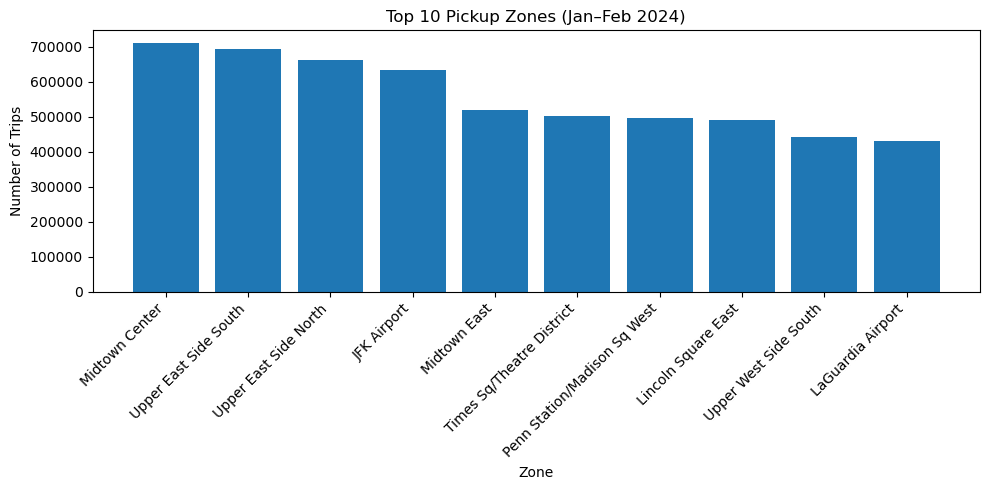

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(top_pu["Zone"], top_pu["trips"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Pickup Zones (Jan–Feb 2024)")
plt.ylabel("Number of Trips")
plt.xlabel("Zone")
plt.tight_layout()
plt.savefig("reports/figures/top10_pickup_zones.png", dpi=300, bbox_inches="tight")
plt.show()


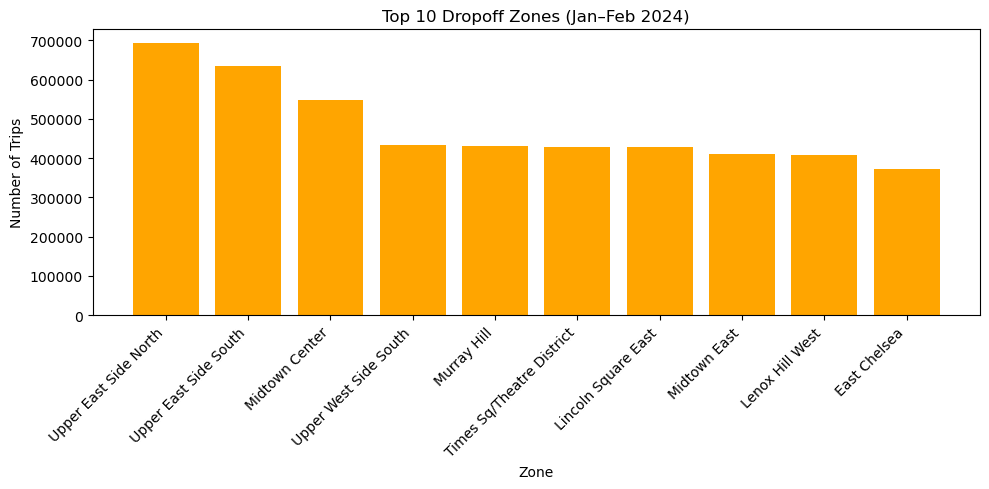

In [44]:
plt.figure(figsize=(10,5))
plt.bar(top_do["Zone"], top_do["trips"], color="orange")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Dropoff Zones (Jan–Feb 2024)")
plt.ylabel("Number of Trips")
plt.xlabel("Zone")
plt.tight_layout()
plt.savefig("reports/figures/top10_dropoff_zones.png", dpi=300, bbox_inches="tight")
plt.show()


In [34]:
#Trips by weekday vs weekend
trips_week = (
    df_clean.groupby("is_weekend")
    .size()
    .reset_index(name="trips")
    .replace({"is_weekend": {False:"Weekday", True:"Weekend"}})
)
trips_week


,is_weekend,trips
0,Weekday,10660390
1,Weekend,3858563


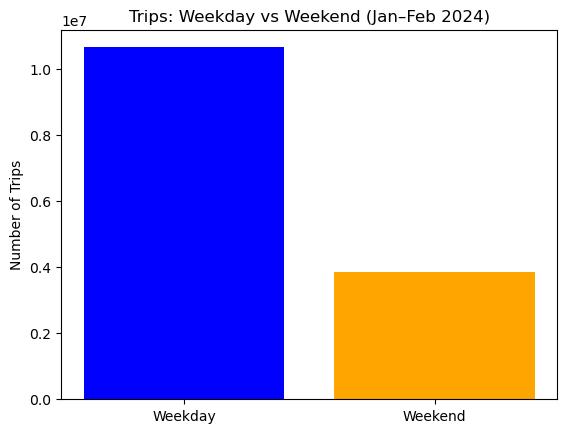

In [45]:
import matplotlib.pyplot as plt

plt.bar(trips_week["is_weekend"], trips_week["trips"], color=["blue","orange"])
plt.title("Trips: Weekday vs Weekend (Jan–Feb 2024)")
plt.ylabel("Number of Trips")
plt.savefig("reports/figures/trips_weekday_vs_weekend.png", dpi=300, bbox_inches="tight")
plt.show()

In [36]:
#Trips by day of week (Mon–Sun)
dow_map = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}
trips_dow = (
    df_clean.groupby("dow")
    .size()
    .reset_index(name="trips")
    .replace({"dow": dow_map})
    .sort_values("dow")
)
trips_dow



,dow,trips
4,Fri,2031216
0,Mon,1788541
5,Sat,2115053
6,Sun,1743510
3,Thu,2563397
1,Tue,2028877
2,Wed,2248359


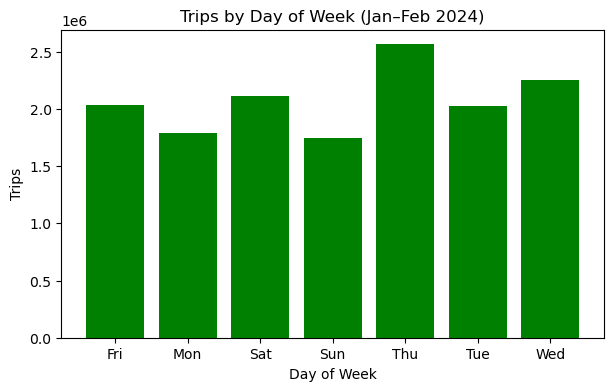

In [46]:
plt.figure(figsize=(7,4))
plt.bar(trips_dow["dow"], trips_dow["trips"], color="green")
plt.title("Trips by Day of Week (Jan–Feb 2024)")
plt.xlabel("Day of Week")
plt.ylabel("Trips")
plt.savefig("reports/figures/trips_by_day_of_week.png", dpi=300, bbox_inches="tight")
plt.show()


In [38]:
#Revenue & trips by payment type
rev_by_pay = (
    df_clean.groupby("payment_type_name")
    .agg(trips=("total_amount","size"),
         total_revenue=("total_amount","sum"),
         avg_total=("total_amount","mean"))
    .reset_index()
    .sort_values("total_revenue", ascending=False)
)
rev_by_pay


,payment_type_name,trips,total_revenue,avg_total
1,Credit card,11550800,3.233184e+08,27.990997
0,Cash,2014106,4.777462e+07,23.720010
4,Other,797994,2.030160e+07,25.440791
2,Dispute,107212,2.717690e+06,25.348748
3,No charge,48841,1.094128e+06,22.401843


In [39]:
# calculate a tip_rate column:

df_clean["tip_rate"] = np.where(                       # create a new column 'tip_rate' in df_clean
    df_clean["total_amount"] > 0,                      # condition: only when total_amount is positive
    df_clean["tip_amount"] / df_clean["total_amount"], # true case: compute tip_rate = tip_amount / total_amount
    np.nan                                             # false case: if total_amount ≤ 0, assign NaN (not defined)
)


In [40]:
# Average tips by payment type

tips_by_pay = (                                         # create a DataFrame summarizing tipping by payment type
    df_clean.groupby("payment_type_name")               # group rows by payment_type_name (Credit card, Cash, etc.)
    .agg(avg_tip_amount=("tip_amount","mean"),          # compute average tip amount per group
         median_tip_amount=("tip_amount","median"),     # compute median tip amount per group (robust to outliers)
         avg_tip_rate=("tip_rate","mean"),              # compute average tip rate (tip/total) per group
         trips=("tip_amount","size"))                   # count how many trips are in each group
    .reset_index()                                      # turn group labels back into a normal column
    .sort_values("avg_tip_amount", ascending=False)     # sort results by highest avg tip amount first
)

tips_by_pay                                             # display the resulting summary table


,payment_type_name,avg_tip_amount,median_tip_amount,avg_tip_rate,trips
1,Credit card,4.134657,3.15,0.147425,11550800
4,Other,1.301343,0.00,0.041243,797994
3,No charge,0.009873,0.00,0.000231,48841
2,Dispute,0.008859,0.00,0.000203,107212
0,Cash,0.000174,0.00,0.000008,2014106


In [41]:
# Tip behavior by month (Jan vs Feb)

tips_by_month = (                         # start building a grouped DataFrame called tips_by_month
    df_clean.groupby("ym")                 # group the cleaned dataset by year-month string ("ym")
    .agg(avg_tip_amount=("tip_amount","mean"),    # calculate the average tip amount per group
         median_tip_amount=("tip_amount","median"), # calculate the median tip amount per group
         avg_tip_rate=("tip_rate","mean")) # calculate the average tip rate (tip/total) per group
    .reset_index()                         # reset the index so "ym" becomes a normal column
    .sort_values("ym")                     # sort results by year-month ascending
)

tips_by_month                              # display the resulting DataFrame


,ym,avg_tip_amount,median_tip_amount,avg_tip_rate
0,2024-01,3.377000,2.74,0.120243
1,2024-02,3.350549,2.74,0.119107


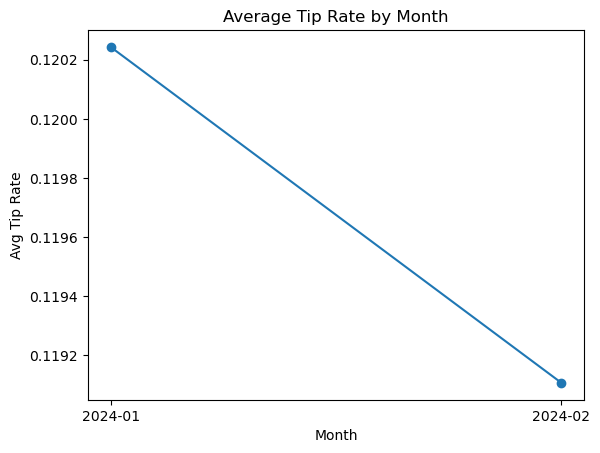

In [47]:
# Plot average tip rate by month
import matplotlib.pyplot as plt   # import matplotlib's pyplot module for plotting

plt.plot(tips_by_month["ym"], tips_by_month["avg_tip_rate"], marker="o")  
# create a line plot with x = month ("ym") and y = average tip rate
# "marker='o'" adds a circular marker at each data point

plt.title("Average Tip Rate by Month")  
# set the title of the plot

plt.xlabel("Month")  
# label the x-axis as "Month"

plt.ylabel("Avg Tip Rate")  
# label the y-axis as "Avg Tip Rate"

plt.savefig("reports/figures/tip_rate_by_month_v2.png", dpi=300, bbox_inches="tight")  
# save the figure as a PNG file in the reports/figures folder
# dpi=300 gives high resolution, bbox_inches="tight" trims whitespace around the figure

plt.show()  
# display the plot in the notebook or script output
